## **Load Data**

Since training would require a lot of data and Spotify is only so generous with their API, I decided to use an external song lyrics dataset from [Kaggle]((https://www.kaggle.com/datasets/terminate9298/songs-lyrics?select=lyrics.csv) ) that includes lyrics from over 25,000 songs, mostly in English, by 500 unique artists. The dataset contains a total of 7,619,966 unique words, providing sufficient data to train a small language model. I added artist names to the dataset hoping this would help the model learn specific artistic styles, thereby enhancing its ability to generate artist-specific lyrics upon inference. I employed byte-pair encoding to tokenize the dataset, which groups together frequently co-occurring characters. The total number of unique words in my dataset was just under 5,000.

In [1]:
pip install bpemb

In [2]:
from bs4 import BeautifulSoup
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import prune
import math
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from datetime import datetime
from torch.utils.data import Dataset
from collections import Counter
from typing import List
from transformers import AutoTokenizer
import pandas as pd
import re
from bpemb import BPEmb

In [3]:
# Load data from CSV, ignoring malformed lines
df = pd.read_csv("/content/lyrics.csv", on_bad_lines='skip')

# Remove the 'link' column as it's not needed
df = df.drop(columns=['link'])

# Calculate number of words in 'lyrics' assuming space as delimiter
df['token_count'] = df['lyrics'].apply(lambda x: len(x.split()))
print("Total number of tokens:", df['token_count'].sum())

# Clean the lyrics text using a predefined function
df['artist'] = df['artist'].str.replace(' Lyrics', '')
df['formatted'] = df.apply(lambda row: row['artist'] + (" " + row['lyrics'] if row['lyrics'] else ""), axis=1)
df['formatted_token_count'] = df['formatted'].apply(lambda x: len(x.split()))
max_formatted_tokens = df['formatted_token_count'].max()
print("Maximum number of tokens in 'formatted':", max_formatted_tokens)

# Determine and print the number of unique artists
unique_artists = df['artist'].nunique()
print("Number of unique artists:", unique_artists)

# Convert the 'formatted' column to lowercase
df['formatted'] = df['formatted'].str.lower()

# Remove unneeded columns to tidy up the DataFrame
df = df.drop(columns=['artist', 'token_count', 'lyrics', 'song_name', 'Unnamed: 0'])

Total number of tokens: 7619966
Maximum number of tokens in 'formatted': 3708
Number of unique artists: 542


In [4]:
class BPETokenizer:
    """
    Tokenizer based on Byte-Pair Encoding (BPE) to manage vocabulary and encoding/decoding of text.
    """
    def __init__(self, lang="en", vs=20000):
        """
        Initialize the BPE tokenizer with specified language and vocabulary size, adding special tokens.
        """
        self.bpemb = BPEmb(lang=lang, vs=vs)
        self.vocab_size = self.bpemb.vocab_size + 2  # Account for PAD and UNK tokens

        # Mapping from words to indices, offset by 2 to accommodate special tokens
        self.word_index = {word: idx + 2 for idx, word in enumerate(self.bpemb.words)}
        self.word_index["<PAD>"] = 0
        self.word_index["<UNK>"] = 1

        # Reverse mapping from indices to words
        self.index_word = {idx: word for word, idx in self.word_index.items()}

    def encode(self, text):
        """
        Convert text to a list of indices. Unknown words are mapped to <UNK>.
        """
        return [self.word_index.get(word, 1) for word in self.bpemb.encode(text)]

    def decode(self, indices):
        """
        Convert a list of indices back to text, skipping special tokens.
        """
        return ''.join(self.index_word.get(idx, "<UNK>") for idx in indices if idx > 1)

    def get_vocab_size(self):
        """
        Return the total vocabulary size, including special tokens.
        """
        return self.vocab_size


class TransformersTextDataset(Dataset):
    """
    Dataset class for text data prepared for training transformer models, handling tokenization and segmentation.
    """
    def __init__(self, texts, seq_length, lang="en", vs=20000):
        """
        Initialize dataset with texts, sequence length, and tokenizer parameters.
        """
        self.tokenizer = BPETokenizer(lang=lang, vs=vs)
        self.seq_length = seq_length
        self.tokenized_segments = self.tokenize_and_segment_texts(texts)

    def tokenize_and_segment_texts(self, texts):
        """
        Tokenize input texts and split into fixed-size segments, padding as needed.
        """
        tokenized_segments = []
        pad_id = self.tokenizer.word_index["<PAD>"]
        for text in texts:
            encoded = self.tokenizer.encode(text)
            padded_length = (len(encoded) + self.seq_length - 1) // self.seq_length * self.seq_length
            encoded.extend([pad_id] * (padded_length - len(encoded)))

            chunks = [encoded[i:i + self.seq_length] for i in range(0, len(encoded), self.seq_length)]
            tokenized_segments.extend(chunks)
        return tokenized_segments

    def unique_words(self):
        """
        Calculate the number of unique words in the tokenized segments, excluding special tokens.
        """
        return len(set(word for segment in self.tokenized_segments for word in segment if word > 1))

    def __len__(self):
        """
        Return the number of segments in the dataset.
        """
        return len(self.tokenized_segments)

    def __getitem__(self, idx):
        """
        Retrieve a pair of input-target sequences from the dataset by index.
        """
        segment = self.tokenized_segments[idx]
        return torch.tensor(segment[:-1], dtype=torch.long), torch.tensor(segment[1:], dtype=torch.long)

In [24]:
texts = df['formatted'].tolist()

dataset = TransformersTextDataset(texts, seq_length=256, vs=5000)
print(f'Number of unique words in dataset: {dataset.unique_words()}')
print(f'Vocabulary size of tokenizer: {dataset.tokenizer.get_vocab_size()}')

# Calculate train/test split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Randomly split dataset into training and testing parts
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Output sizes of the splits
print(f'Training dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

# Create DataLoaders for batch processing of training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Number of unique words in dataset: 4859
Vocabulary size of tokenizer: 5002
Training dataset size: 52744
Test dataset size: 13187


In [21]:
# Use GPU if available (I used L4 from Google Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## **GQA Transformer**

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The efficiency of transformer models is largely governed by the computation of the attention matrix, where each query is dot-producted with a key, comparing each token to every other token within the layer. This results in a computational complexity of $O(n^2)$, where $n$ is the dimension of the model, and becomes a major bottleneck when training larger models, particularly those with more heads or larger context sizes.

Techniques such as sparse attention and flash attention are designed to tackle this $O(n^2)$ scaling have already been used in the past. Here we will look at two very recent techniques GQA and MoD.
In [grouped query attention](https://arxiv.org/pdf/2305.13245.pdf), instead of maintaining a unique key matrix for each head in a standard multi-head layer, we use fewer key matrices, with multiple query matrices interacting with the same key. This configuration reduces the number of parameters and accelerates training time. By grouping the queries into $G$ groups, we effectively reduce complexity; when $G$ equals the number of heads, the architecture reverts to that of a standard transformer. Changing the number of Heads is a tradeoff between speed and accuracy, with lower numbers leading to signifiantly faster run times yet with poorer accuracy.

For my implementation, I adapted a component from the in-development [grouped-query-attention-library](https://github.com/fkodom/grouped-query-attention-pytorch/blob/main/README.md) to include a Grouped Query (GQ) Attention block in each transformer layer, replacing the conventional multi-head setup. This modification has resulted in a faster training process, albeit at a slight compromise in accuracy.

### **Existing Code**

In [6]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.1 MB/s eta 0:00:00


In [7]:
from typing import Optional, Tuple, Union
import torch
import torch.nn.functional as F
from einops import einsum, rearrange
from torch import Tensor, nn

def scaled_dot_product_gqa(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    dropout: float = 0.1,
    scale: Optional[float] = None,
    mask: Optional[Tensor] = None,
    is_causal: Optional[bool] = True,
    need_weights: bool = False,
    average_attn_weights: bool = False,
    force_grouped: bool = False,
):
    """Scaled dot product attention with support for grouped queries.

    Einstein notation:
    - b: batch size
    - n / s: sequence length
    - h: number of heads
    - g: number of groups
    - d: dimension of query/key/value

    Args:
        query: Query tensor of shape (b, n, h, d)
        key: Key tensor of shape (b, s, h, d)
        value: Value tensor of shape (b, s, h, d)
        dropout: Dropout probability (default: 0.0)
        scale: Scale factor for query (default: d_query ** 0.5)
        mask: Mask tensor of shape (b, n, s) or (b, s). If 'ndim == 2', the mask is
            applied to all 'n' rows of the attention matrix. (default: None)
        force_grouped: If True, apply grouped-query attention even if the number of
            heads is equal for query, key, and value. (default: False)

    Returns:
        2-tuple of:
        - Attention output with shape (b, n, h, d)
        - (Optional) Attention weights with shape (b, h, n, s). Only returned if
          'need_weights' is True.
    """
    if (mask is not None) and (is_causal is not None):
        raise ValueError(
            "Only one of 'mask' and 'is_causal' should be provided, but got both."
        )
    elif not query.ndim == key.ndim == value.ndim == 4:
        raise ValueError(
            f"Expected query, key, and value to be 4-dimensional, but got shapes "
            f"{query.shape}, {key.shape}, and {value.shape}."
        )

    # Move sequence length dimension to axis 2.
    # This makes the attention operations below *much* faster.
    query = rearrange(query, "b n h d -> b h n d")
    key = rearrange(key, "b s h d -> b h s d")
    value = rearrange(value, "b s h d -> b h s d")

    bq, hq, nq, dq = query.shape
    bk, hk, nk, dk = key.shape
    bv, hv, nv, dv = value.shape
    if not (bq == bk == bv and dq == dk == dv):
        raise ValueError(
            "Expected query, key, and value to have the same batch size (dim=0) and "
            f"embedding dimension (dim=3), but got query: {query.shape}, "
            f"key: {key.shape}, and value: {value.shape}."
        )
    elif (hk != hv) or (nk != nv):
        raise ValueError(
            "Expected key and value to have the same size in dimensions 1 and 2, but "
            f"got key: {key.shape} and value: {value.shape}."
        )
    elif hq % hk != 0:
        raise ValueError(
            "Expected query heads to be a multiple of key/value heads, but got "
            f"query: {query.shape} and key/value: {key.shape}."
        )

    if scale is None:
        scale = query.size(-1) ** 0.5
    query = query / scale

    num_head_groups = hq // hk
    if num_head_groups > 1 or force_grouped:
        # Separate the query heads into 'num_head_groups' chunks, and fold the group
        # dimension into the batch dimension.  This allows us to compute the attention
        # for each head in parallel, then sum over all of the groups at the end.
        query = rearrange(query, "b (h g) n d -> b g h n d", g=num_head_groups)
        similarity = einsum(query, key, "b g h n d, b h s d -> b h n s")
    else:
        # If the number of query/key heads is equal, we can skip grouping the queries,
        # and just use the standard sdot product attention.
        similarity = einsum(query, key, "b h n d, b h s d -> b h n s")

    if is_causal:
        # Mask out the upper triangular portion of the attention matrix. This prevents
        # the model from attending to tokens in the future.
        mask = torch.ones(
            (bq, nq, nk),
            device=query.device,
            dtype=torch.bool,
        ).tril_()

    if mask is not None:
        # Expand mask to match the shape of the attention matrix.
        # If mask is 2D, assume that it is applied to the key/value sequence dimension.
        # Else if mask is 3D, assume that it is applied to the query/key/value sequence
        # dimension for all attention heads.
        #
        # Users could also provide a 4D mask, which is applied to the query/key/value
        # sequence dimension for each attention head (though I don't have a particular
        # use case in mind for that).
        if mask.ndim == 2:
            mask = rearrange(mask, "b s -> b () () s")
        elif mask.ndim == 3:
            mask = rearrange(mask, "b n s -> b () n s")
        # Mask similarity values by setting them to negative infinity.  This guarantees
        # that they will not contribute to the softmax computation below.
        similarity.masked_fill_(~mask, torch.finfo(similarity.dtype).min)

    attention = F.softmax(similarity / scale, dim=-1)
    if 0.1 > 0.0:
        attention = F.dropout(attention, p=0.1)

    # Apply attention matrix to the value Tensor.
    out = einsum(attention, value, "b h n s, b h s d -> b h n d")
    # Move head dimension back to axis 2
    out = rearrange(out, "b h n d -> b n h d")

    attn_weights: Optional[Tensor] = None
    if need_weights:
        # Move the sequence dimensions back to positions 1, 2.  Move the head dimension
        # to position 3.  This more closely matches the return shape of the attention
        # output: (b, n, h, d).
        attn_weights = rearrange(attention, "b h n s -> b n s h")
        if average_attn_weights:
            attn_weights = attn_weights.mean(dim=1)

    return out, attn_weights


class MultiheadGQA(nn.Module):

    def __init__(
        self,
        embed_dim: int,
        query_heads: int,
        kv_heads: int,
        dropout: float = 0.1,
        bias: bool = True,
        layer_norm: bool = True,
        layer_norm_eps: float = 1e-5,
        gamma_init: float = 1.0,
        device: Optional[Union[torch.device, str]] = None,
        dtype: Optional[torch.dtype] = None,
        batch_first: bool = False
    ):
        super().__init__()
        self.query_heads = query_heads
        self.kv_heads = kv_heads
        self.dropout = dropout
        self.layer_norm = layer_norm
        self.gamma_init = gamma_init
        self.batch_first = batch_first

        if self.query_heads % self.kv_heads != 0:
            raise ValueError(
                f"query_heads ({query_heads}) must be divisible by "
                f"kv_heads ({kv_heads})"
            )
        elif (embed_dim % self.query_heads != 0) or (embed_dim % self.kv_heads != 0):
            raise ValueError(
                f"embed_dim ({embed_dim}) must be divisible by "
                f"query_heads ({query_heads}) and kv_heads ({kv_heads})"
            )

        head_dim = embed_dim // query_heads
        if not head_dim % 8 == 0:
            raise ValueError(
                f"head_dim (embed_dim / num_heads = {head_dim}) must be divisible by 8"
            )
        if not head_dim <= 128:
            raise ValueError(
                f"head_dim (embed_dim / num_heads = {head_dim}) must be <= 128"
            )

        # Query projection layer is the same as in vanilla MHA.
        self.q_proj = nn.Linear(
            embed_dim, embed_dim, bias=bias, device=device, dtype=dtype
        )
        # Key/value projection layers have a smaller output dimension, so that
        # the we have fewer key/value attention heads after reshaping.
        kv_embed_dim = embed_dim // query_heads * kv_heads
        self.k_proj = nn.Linear(
            embed_dim, kv_embed_dim, bias=bias, device=device, dtype=dtype
        )
        self.v_proj = nn.Linear(
            embed_dim, kv_embed_dim, bias=bias, device=device, dtype=dtype
        )
        self.norm: Optional[nn.LayerNorm] = None
        if layer_norm:
            self.norm = nn.LayerNorm(
                kv_embed_dim, eps=layer_norm_eps, device=device, dtype=dtype
            )

        self.out_proj = nn.Linear(
            kv_embed_dim, embed_dim, bias=bias, device=device, dtype=dtype
        )

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_normal_(self.q_proj.weight)
        if self.q_proj.bias is not None:
            nn.init.constant_(self.q_proj.bias, 0)
        nn.init.xavier_normal_(self.k_proj.weight)
        if self.k_proj.bias is not None:
            nn.init.constant_(self.k_proj.bias, 0)

        nn.init.xavier_normal_(self.v_proj.weight, gain=self.gamma_init)
        if self.v_proj.bias is not None:
            nn.init.constant_(self.v_proj.bias, 0)
        nn.init.xavier_normal_(self.out_proj.weight, gain=self.gamma_init)
        if self.out_proj.bias is not None:
            nn.init.constant_(self.out_proj.bias, 0)

    def forward(
        self,
        query: Tensor,
        key: Tensor,
        value: Tensor,
        need_weights: bool = False,
        # TODO
        # attn_mask: Optional[Tensor] = None,
        is_causal: bool = True,
        average_attn_weights: bool = False,
    ) -> Tuple[Tensor, Optional[Tensor]]:
        # Notation:
        #   b - batch size
        #   n - sequence length
        #   h - number of heads
        #   d - embedding dimension
        #
        # Input shape: (b, n, d)
        q: Tensor = self.q_proj(query)
        k: Tensor = self.k_proj(key)
        v: Tensor = self.v_proj(value)

        # Unfold 'd' dimension into 'h' separate attention heads.
        q = rearrange(q, "b n (h d) -> b n h d", h=self.query_heads)
        k = rearrange(k, "b n (h d) -> b n h d", h=self.kv_heads)
        v = rearrange(v, "b n (h d) -> b n h d", h=self.kv_heads)
        # Apply attention, then fold 'h' attention heads back into 'd'.
        x, attn = scaled_dot_product_gqa(
            query=q,
            key=k,
            value=v,
            # TODO
            # mask=attn_mask,
            is_causal=is_causal,
            need_weights=need_weights,
            average_attn_weights=average_attn_weights,
            force_grouped=False,
        )
        x = rearrange(x, "b n h d -> b n (h d)")

        if self.layer_norm:
            assert self.norm is not None
            x = self.norm(x)
        # Linear projection on attention outputs.
        x = self.out_proj(x)

        return x, attn

## **MoD Transformer**

A recent advancement aimed at addressing the scalability challenges of the self-attention layer is the [Mixture of Depths](https://arxiv.org/pdf/2404.02258.pdf) routing. This technique involves a routing layer that learns to select only the top p most effective tokens for processing, with research suggesting that the optimal value for p is 12.5%. Tokens not selected are passed directly to the subsequent layer via a residual connection. This approach increases the number of parameters linearly with n, where n represents the number of tokens in an attention head, but it reduces the computational load by some factor of n^2, enhancing computational efficiency but also learning to pay attention intelligently. The resulting network generally achieves a loss comparable to that of a slower, conventional vanilla network. Typically, this routing is applied every other layer to preserve essential information. In my project, I adapted an implementation by [George Grigorev](https://github.com/thepowerfuldeez/OLMo/blob/main/olmo/mod.py) from GitHub to successfully employ this technique, which significantly accelerated the training process. The implementation uses a MoD wrapper layer which applies the routing before passing the tokens to a standard transformer block.

### **Existing Code**

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

In [9]:
import torch
import torch.nn as nn

class MoD(nn.Module):
    """The Mixtures of Depth Block that dynamically selects which tokens to process in a block.
    Wraps around a decoder block to allow for token dropping, optimizing computational resources.
    """

    def __init__(self, config, block):
        super().__init__()
        self.block = block  # block is attention + MLP
        self.capacity_factor = config.mod_capacity_factor
        self.top_k = int(self.capacity_factor * config.max_sequence_length)

        if self.capacity_factor < 1:
            # Initialize routers only if capacity factor is less than 1
            self.mod_router = nn.Linear(config.d_model, 1, bias=False)
            self.mlp_router = nn.Linear(config.d_model, 1, bias=False)

        # BCE loss is used for inference
        self.bce_loss = nn.BCEWithLogitsLoss()

    def reset_parameters(self):
        self.block.reset_parameters()
        if self.capacity_factor < 1:
            self.mod_router.reset_parameters()
            self.mlp_router.reset_parameters()

    def set_activation_checkpointing(self, strategy):
        self.block.set_activation_checkpointing(strategy)

    def get_aux_loss(self, x, targets):
        if self.capacity_factor < 1:
            B, T, C = x.shape
            mlp_router_logits = self.mlp_router(x.detach().view(B * T, -1))
            return self.bce_loss(mlp_router_logits.view(-1), targets)
        else:
            return torch.tensor(0.0).to(x.device)

    def forward(self, x, memory=None, **kwargs):
        B, T, C = x.shape
        if self.capacity_factor < 1:
            top_k = min(self.top_k, int(self.capacity_factor * T))

            """STEP 1: get logits and top_k tokens"""
            router_logits = self.mod_router(x)
            weights, selected_tokens = torch.topk(router_logits, top_k, dim=1, sorted=False)

            # 0, if not in topk tokens, 1 else
            mlp_targets = torch.zeros_like(router_logits).view(-1)
            mlp_targets[selected_tokens.view(-1)] = 1.0
            aux_loss = self.get_aux_loss(x, mlp_targets)

            # IMPORTANT: need to sort indices to keep causal order for those tokens that
            # are processed in a block
            selected_tokens, index = torch.sort(selected_tokens, dim=1)
            weights = torch.gather(weights, dim=1, index=index)

            """STEP 2: expand indices to process batches with _reduced_ seqlen"""
            indices_expanded = selected_tokens.expand(-1, -1, C)
            top_k_tokens = torch.gather(x, 1, indices_expanded)

            # Make sure to pass both 'tgt' and 'memory' to the TransformerDecoderLayer
            if memory is None:
                memory = top_k_tokens  # Use self-attention if no external memory is provided

            top_k_tokens_processed, cache = self.block(top_k_tokens, memory, **kwargs)

            """STEP 3: combine results"""
            x = torch.scatter_add(
                x,
                dim=1,
                index=indices_expanded,
                src=top_k_tokens_processed * weights,
            )
            return x, cache, aux_loss
        else:
            # When capacity factor is 1, process all tokens as a vanilla Transformer layer
            x_processed, cache = self.block(x, memory, **kwargs)
            return x_processed, cache, torch.tensor(0.0).to(x.device)

## **Frankestein**

Since both applications are compatible, I wanted to know if they could be implemented in a single architecture with faster speed or better performance. I decided to create a “Frankenstein” using these. Since MoD accepts any block to wrap, I decided to create a transformer block with GQ Attention instead of multi-head and decided to pass it.

Here is a comparison between the standard approach and my hybrid. Standard:


```
  Input: tokens, original_dim = n
  Output: softmax output of dimensions matching vocab_size

  For each layer in model_layers:
      original_tokens = tokens  # Save the input to the layer for the residual connection
      tokens = layer_norm(tokens)  # Normalize the input tokens for the layer

      head_outputs = []

      For each head in num_heads:
          Q = derive_query_matrix(tokens, dim_q)
          K = derive_key_matrix(tokens, dim_k)
          V = derive_value_matrix(tokens, dim_v)
          head_output = attention(Q, K, V)  # Compute attention output
          head_outputs.append(head_output)

      tokens = concatenate(head_outputs)
      tokens = sum(tokens)  # Sum the outputs from all heads
      tokens += original_tokens  # Add the residual connection here

      tokens = batch_norm(tokens)  # Normalize the combined output
      original_tokens_ffn = tokens  # Save the output for the residual connection post-FFN
      tokens = FFN(tokens)  # Apply the feed-forward network
      tokens += original_tokens_ffn  # Add the residual connection after the FFN

  tokens = proj(tokens, dim = vocab_size)  # Project output tokens to vocabulary size
  output = softmax(tokens)  # Apply softmax to get probability distribution over vocabulary

```

Frankenstein Transformer:

```
Input: tokens, dim = n
Output: softmax output of dimensions matching vocab_size

For each layer in model_layers:
    original_tokens = tokens  # Save the input to the layer for the residual connection

    If layer_number % 2 == 0:
        tokens = MoD-routing(tokens, p=1)  # Apply MoD-routing with p=1 (full routing) for even layers
    Else:
        tokens = MoD-routing(tokens, p=0.125)  # Apply MoD-routing with p=0.125 for odd layers

    tokens = layer_norm(tokens)  # Normalize the inputs for the layer

    head_outputs = []
    For each head in num_heads:
        Q = derive_query_matrix(tokens, dim_q)
        K = derive_key_matrix(tokens, dim_k)
        V = derive_value_matrix(tokens, dim_v)
        head_output = grouped-query-attention(Q, K, V)  # Grouped-query attention where number of K, V <= Q
        head_outputs.append(head_output)

    tokens = concatenate(head_outputs)
    tokens = sum(tokens)  # Sum the outputs from all heads
    tokens += original_tokens  # Add the residual connection after attention sum

    tokens = batch_norm(tokens)  # Normalize the combined output
    original_tokens_ffn = tokens  # Save the output for the residual connection post-FFN
    tokens = FFN(tokens)  # Apply the feed-forward network post normalization
    tokens += original_tokens_ffn  # Add the residual connection after the FFN

tokens = proj(tokens, dim = vocab_size)  # Project output tokens to vocabulary size
output = softmax(tokens)  # Apply softmax to get probability distribution over vocabulary
```

This is one of the first implementations of MoD since it has only come out recently, and the only implementation combining it with GQA.

In [10]:
class TransformerDecoderLayerGQA(nn.Module):
    def __init__(self, embed_dim, query_heads, kv_heads, dim_feedforward=2048):
        super().__init__()
        self.self_attn = MultiheadGQA(embed_dim, query_heads, kv_heads)  # Using MultiheadGQA for self-attention
        self.norm1 = nn.LayerNorm(embed_dim)
        self.linear1 = nn.Linear(embed_dim, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, tgt, tgt_mask=None, tgt_key_padding_mask=None, tgt_is_causal=True):
        # Here, memory and tgt are the same as we are in a decoder-only model
        # Using tgt as both query, key, and value for self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, need_weights=False, is_causal=tgt_is_causal)
        tgt = tgt + self.norm1(tgt2)  # Apply residual connection followed by normalization
        tgt2 = self.linear2(F.relu(self.linear1(tgt)))  # Feed-forward network
        tgt = tgt + self.norm2(tgt2)  # Another residual connection and normalization
        cache = None
        return tgt, None

class Frankenstein(nn.Module):
    def __init__(self, config):
        super(Frankenstein, self).__init__()
        self.embedding = nn.Embedding(config.num_tokens, config.d_model)
        self.pos_encoder = self.create_positional_encoding(config.max_sequence_length, config.d_model)
        # Layers wrapped in MoD
        self.layers = nn.ModuleList([
            MoD(config if i % 2 == 0 else self.modify_config(config, config.mod_reduced),
                TransformerDecoderLayerGQA(config.d_model, config.query_heads, config.kv_heads, config.dim_feedforward))
            for i in range(config.num_layers)
        ])
        self.norm = nn.LayerNorm(config.d_model)
        self.final_linear = nn.Linear(config.d_model, config.num_tokens)

    def modify_config(self, config, mod_capacity_factor):
        config_copy = config.__class__(**{k: v for k, v in vars(config).items()})
        setattr(config_copy, 'mod_capacity_factor', mod_capacity_factor)
        return config_copy

    def create_positional_encoding(self, length, d_model):
        position = torch.arange(length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pos_encoder = torch.zeros(length, d_model)
        pos_encoder[:, 0::2] = torch.sin(position * div_term)
        pos_encoder[:, 1::2] = torch.cos(position * div_term)
        return nn.Parameter(pos_encoder.unsqueeze(0))

    def forward(self, src):
        src = self.embedding(src) + self.pos_encoder[:, :src.size(1), :]
        memory = None

        aux_losses = []
        for layer in self.layers:
            src, cache, aux_loss = layer(src, memory)
            aux_losses.append(aux_loss)

        src = self.final_linear(self.norm(src))
        return src, sum(aux_losses) / len(aux_losses) if aux_losses else 0

In [ ]:
class Config:
    max_sequence_length = 256
    num_tokens = 5002  # vocabulary size
    d_model = 256  # dimensionality of the token embeddings
    query_heads = 8  # number of query heads in multi-head attention mechanisms
    kv_heads = 2  # number of key/value heads in multi-head attention mechanisms
    dim_feedforward = 512  # dimension of the feedforward network model in transformer
    num_layers = 4  # number of decoder layers
    mod_capacity_factor = 1  # default capacity factor
    mod_reduced = 0.125 # This amount of tokens in every other layer will pass through

In [ ]:
config = Config()
model = Frankenstein(config).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 3

# Training Loop
for epoch in range(epochs):
    start_time = datetime.now()
    model.train()
    total_loss = 0
    total_aux_loss = 0

    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output, aux_loss = model(inputs)
        output = output.reshape(-1, config.num_tokens)
        targets = targets.reshape(-1)
        loss = loss_fn(output, targets)
        total_loss = loss.item() + aux_loss

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate losses for logging
        total_loss += loss.item()
        total_aux_loss += aux_loss.item()

    # Calculate training duration
    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()

    print(f"Epoch {epoch + 1}, Total Loss: {total_loss:.2f}, Auxiliary Loss: {total_aux_loss:.2f}, Training Time: {training_time} seconds")

Epoch 1, Total Loss: 7.24, Auxiliary Loss: 519.90, Training Time: 48.519385 seconds
Epoch 2, Total Loss: 7.06, Auxiliary Loss: 551.90, Training Time: 48.657121 seconds
Epoch 3, Total Loss: 6.28, Auxiliary Loss: 565.11, Training Time: 48.700475 seconds


In [ ]:
# Set the model to evaluation mode
model.eval()

# Print the parameter counts per layer
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} has {param.numel()} trainable parameters")

# Approximate model size by counting parameters
model_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has approximately {model_parameters} trainable parameters.')

pos_encoder has 16384 trainable parameters
embedding.weight has 640256 trainable parameters
layers.0.block.self_attn.q_proj.weight has 16384 trainable parameters
layers.0.block.self_attn.q_proj.bias has 128 trainable parameters
layers.0.block.self_attn.k_proj.weight has 4096 trainable parameters
layers.0.block.self_attn.k_proj.bias has 32 trainable parameters
layers.0.block.self_attn.v_proj.weight has 4096 trainable parameters
layers.0.block.self_attn.v_proj.bias has 32 trainable parameters
layers.0.block.self_attn.norm.weight has 32 trainable parameters
layers.0.block.self_attn.norm.bias has 32 trainable parameters
layers.0.block.self_attn.out_proj.weight has 4096 trainable parameters
layers.0.block.self_attn.out_proj.bias has 128 trainable parameters
layers.0.block.norm1.weight has 128 trainable parameters
layers.0.block.norm1.bias has 128 trainable parameters
layers.0.block.linear1.weight has 65536 trainable parameters
layers.0.block.linear1.bias has 512 trainable parameters
layers.

## **Comparison**

I compared my initial models below based on perplexity scores and times. However, these might not be the most accurate due to slightly different model architectures due to tweaking during debugging each model, so in Part II, I use particular instances of Frankenstein to emulate each of the other architectures. Therefore, those results are better, but this is generally consistent with them, too.

In [11]:
# Count number of paramaeters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def calculate_perplexity(model, data_loader, loss_fn, device, vocab_size):
    """
    Calculate the perplexity of a language model, which measures how well the model predicts a sample.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        data_loader (DataLoader): DataLoader providing input and target batches.
        loss_fn (callable): Loss function used to evaluate model performance.
        device (str or torch.device): Device to run the model computations on ('cpu' or 'cuda').
        vocab_size (int): The size of the vocabulary, not used in this function directly.

    Returns:
        float: The perplexity score for the given data.
    """

    model.eval()  # Switch the model to evaluation mode (e.g., disable dropout).

    total_loss = 0.0  # Initialize total loss accumulated across all batches.
    total_items = 0  # Initialize total number of items processed (for averaging loss later).

    with torch.no_grad():  # Context manager that disables gradient computation, reducing memory usage and speeding up computations.
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device.

            outputs = model(inputs)  # Compute the model's output for the given inputs.

            if isinstance(outputs, tuple):  # Check if model returns a tuple (e.g., output and hidden states).
                outputs = outputs[0]  # If so, use only the logits (first element of tuple) for loss calculation.

            outputs = outputs.reshape(-1, vocab_size)  # Flatten the outputs to fit the loss function's requirements.
            targets = targets.reshape(-1)  # Flatten the targets accordingly.

            loss = loss_fn(outputs, targets)  # Compute the loss between outputs and targets.
            total_loss += loss.item() * inputs.size(0)  # Aggregate the loss scaled by batch size for correct averaging.
            total_items += inputs.size(0)  # Accumulate the total number of items processed.

    average_loss = total_loss / total_items  # Calculate the average loss over all items.
    perplexity = torch.exp(torch.tensor(average_loss))  # Compute the perplexity from the average loss.

    return perplexity.item()  # Return the perplexity score as a Python float.

I realized the only way to have a perfect "control" architecture would be to compare Frankenstein to itself. Since an MoD router with p = 1 lets all tokens through on all layers, it becomes a standard transformer. Likewise, when the number of key and value matrices are equal to query matrices, a GQ Attention system is essentially standard multi-head attention.
I initalized 4 instances of the Frankenstein:
- p = 1, KV_Heads = 8 (Standard Implementation)
- P = 0.25, KV_Heads = 8 (MoD Implementation)
- p = 1, KV_Heads = 2 (GQA Implementation)
- p = 0.25, KV_HEADS = 2 (Hybrid Implementation)

As can be seen in the results below, which vary a little by data, the hybrid implementation results in faster training than MoD or GQA alone, yet their performance in terms of perplexity is somewhere between MoD's superior performance and GQA's.

The speed boost is only occuring when I train on CPUs, while on GPUs the vanilla architecture is typically slightly faster and I am assuming this is since PyTorch and CUDA kernels are optimized for running standard archtectures. It was interesting to learn that these factors that we are blind to can matter; the author of the GQA library mentions that GQA is only marginally faster than a standard transformer on PyTorch because PyTorch "standard" implimentations already use in-built techniques like flash attention.

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)
epochs = 3

# Define unique configuration classes
class Config1:
    max_sequence_length = 256
    num_tokens = 5002
    d_model = 256
    query_heads = 8
    kv_heads = 8
    dim_feedforward = 512
    num_layers = 4
    mod_capacity_factor = 1
    mod_reduced = 1

class Config2:
    max_sequence_length = 256
    num_tokens = 5002
    d_model = 256
    query_heads = 8
    kv_heads = 2
    dim_feedforward = 512
    num_layers = 4
    mod_capacity_factor = 1
    mod_reduced = 1

class Config3:
    max_sequence_length = 256
    num_tokens = 5002
    d_model = 256
    query_heads = 8
    kv_heads = 8
    dim_feedforward = 512
    num_layers = 4
    mod_capacity_factor = 1
    mod_reduced = 0.25

class Config4:
    max_sequence_length = 256
    num_tokens = 5002
    d_model = 256
    query_heads = 8
    kv_heads = 2
    dim_feedforward = 512
    num_layers = 4
    mod_capacity_factor = 1
    mod_reduced = 0.25

configs = [Config1, Config2, Config3, Config4]
models = []
train_meta = []

# Training loop for each configuration class
for Config in configs:
    model = Frankenstein(Config()).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start_time = datetime.now()
    total_loss = 0

    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output, aux_loss = model(inputs)
            output = output.reshape(-1, Config.num_tokens)
            targets = targets.reshape(-1)
            loss = loss_fn(output, targets) + aux_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    training_duration = (datetime.now() - start_time).total_seconds()
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    models.append(model)
    train_meta.append((training_duration, num_params))

    print(f"Training completed: KV Heads = {Config.kv_heads}, Mod Reduced = {Config.mod_reduced}, Time = {training_duration:.2f} sec, Params = {num_params}")

Training completed: KV Heads = 8, Mod Reduced = 1, Time = 527.36 sec, Params = 4742538
Training completed: KV Heads = 2, Mod Reduced = 1, Time = 317.63 sec, Params = 4149642
Training completed: KV Heads = 8, Mod Reduced = 0.25, Time = 360.57 sec, Params = 4743562
Training completed: KV Heads = 2, Mod Reduced = 0.25, Time = 243.19 sec, Params = 4150666


In [ ]:
vocab_size = 5002

perplexities = [
    calculate_perplexity(models[0], test_loader, loss_fn, device, vocab_size),
    calculate_perplexity(models[1], test_loader, loss_fn, device, vocab_size),
    calculate_perplexity(models[2], test_loader, loss_fn, device, vocab_size),
    calculate_perplexity(models[3], test_loader, loss_fn, device, vocab_size)
]

model_names = ["Vanilla Transformer", "GQA", "MoD", "Frankenstein"]
results = []

for i, model in enumerate(models):
    results.append({
        "Model Name": model_names[i],
        "Training Time (s)": train_meta[i][0],
        "Number of Parameters": train_meta[i][1],
        "Perplexity": perplexities[i]
    })

# Print results in a table
print(f"{'Model Name':<20} | {'Training Time (s)':<17} | {'Number of Parameters':<20} | {'Perplexity':<10}")
print("-" * 75)
for result in results:
    print(f"{result['Model Name']:<20} | {result['Training Time (s)']:<17.2f} | {result['Number of Parameters']:<20} | {result['Perplexity']:<10.2f}")

Model Name           | Training Time (s) | Number of Parameters | Perplexity
---------------------------------------------------------------------------
Vanilla Transformer  | 527.36            | 4742538              | 11.47     
GQA                  | 317.63            | 4149642              | 13.18     
MoD                  | 360.57            | 4743562              | 14.36     
Frankenstein         | 243.19            | 4150666              | 15.58     


In [ ]:
for i, model in enumerate(models):
    # Saving the model
    torch.save(model.state_dict(), f"/content/{model_names[i]}_model.pth")

    results.append({
        "Model Name": model_names[i],
        "Training Time (s)": train_meta[i][0],
        "Number of Parameters": train_meta[i][1],
        "Perplexity": perplexities[i]
    })

---------------------------------------------------------------------------
Vanilla Transformer  | 527.36            | 4742538              | 11.47     
GQA                  | 317.63            | 4149642              | 13.18     
MoD                  | 360.57            | 4743562              | 14.36     
Frankenstein         | 243.19            | 4150666              | 15.58     
Vanilla Transformer  | 527.36            | 4742538              | 11.47     
GQA                  | 317.63            | 4149642              | 13.18     
MoD                  | 360.57            | 4743562              | 14.36     
Frankenstein         | 243.19            | 4150666              | 15.58     


## **Inference**

In [25]:
class RMSLayerNorm(nn.Module):
    """
    Implements RMS Layer Normalization that normalizes the input features based on the root mean square of
    the input minus its mean. This is an alternative to the standard Layer Normalization technique.
    """
    def __init__(self, normalized_shape, eps=1e-5):
        """
        Initialize the RMSLayerNorm module.

        Args:
            normalized_shape (int or tuple): The shape of the input tensor that should be normalized.
                                             This typically corresponds to the features dimension.
            eps (float, optional): A small constant (epsilon) added to the denominator for numerical stability.
                                   Defaults to 1e-5.
        """
        super().__init__()  # Initialize the parent class (nn.Module)
        self.weight = nn.Parameter(torch.ones(normalized_shape))  # Learnable scale parameters
        self.bias = nn.Parameter(torch.zeros(normalized_shape))  # Learnable shift parameters
        self.eps = eps  # Small constant for numerical stability

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the RMS layer normalization.

        Args:
            x (Tensor): The input tensor to be normalized.

        Returns:
            Tensor: The normalized tensor which is scaled and shifted by learnable parameters.
        """
        mean = x.mean(dim=-1, keepdim=True)  # Compute the mean of the last dimension
        squared_mean = (x ** 2).mean(dim=-1, keepdim=True)  # Compute the mean of the squares of the last dimension
        rms = torch.sqrt(squared_mean - mean**2 + self.eps)  # Compute the root mean square deviation for normalization
        x = (x - mean) / rms  # Normalize the input tensor
        return self.weight * x + self.bias  # Scale and shift the normalized tensor and return

In [26]:
class TransformerDecoderLayerGQA(nn.Module):
    def __init__(self, embed_dim, query_heads, kv_heads, dim_feedforward=2048):
        super().__init__()
        self.self_attn = MultiheadGQA(embed_dim, query_heads, kv_heads)  # Using MultiheadGQA for self-attention
        self.norm1 = RMSLayerNorm(embed_dim)
        self.linear1 = nn.Linear(embed_dim, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, embed_dim)
        self.norm2 = RMSLayerNorm(embed_dim)

    def forward(self, tgt, tgt_mask=None, tgt_key_padding_mask=None, tgt_is_causal=True):
        # Here, memory and tgt are the same as we are in a decoder-only model
        # Using tgt as both query, key, and value for self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, need_weights=False, is_causal=tgt_is_causal)
        tgt = tgt + self.norm1(tgt2)  # Apply residual connection followed by normalization
        tgt2 = self.linear2(F.relu(self.linear1(tgt)))  # Feed-forward network
        tgt = tgt + self.norm2(tgt2)  # Another residual connection and normalization
        cache = None
        return tgt, None

In [27]:
# Save and checkpoint model weights
def save_model_weights(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model weights saved to {filepath}")

In [28]:
def init_weights(m):
    # Check if the module is a linear layer (fully connected layer)
    if isinstance(m, torch.nn.Linear):
        # Initialize the weights of the linear layer using Xavier uniform distribution.
        # This helps keep the signal in a reasonable range during the initial stages of training.
        torch.nn.init.xavier_uniform_(m.weight)
        # If the linear layer includes a bias term, initialize it to zero.
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

    # Check if the module is a layer normalization layer
    elif isinstance(m, torch.nn.LayerNorm):
        # Initialize the weights of the LayerNorm layer to one.
        # This is standard practice to maintain the output's scale as training starts.
        torch.nn.init.constant_(m.weight, 1)
        # Initialize the bias of the LayerNorm layer to zero.
        torch.nn.init.constant_(m.bias, 0)

In [36]:
import datetime
import matplotlib.pyplot as plt

In [32]:
# Configuration and Model Setup
class Config:
    # Configuration class for storing model and training parameters
    max_sequence_length = 256
    num_tokens = 5002
    d_model = 256
    query_heads = 16
    kv_heads = 4
    dim_feedforward = 512
    num_layers = 8
    mod_capacity_factor = 1
    mod_reduced = 0.25

config = Config()
model = Frankenstein(config).to(device)  # Instantiate model with the given configuration and move to device
model.apply(init_weights)  # Apply weight initialization using the init_weights function
loss_fn = nn.CrossEntropyLoss().to(device)  # Define the loss function and move to the appropriate device
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Set up the optimizer with weight decay
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)  # Scheduler for adjusting learning rate

# Parameters
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Determine whether CUDA is available

# Training and Evaluation
train_losses = []
test_losses = []
time_list = []

for epoch in range(epochs):
    start_time = datetime.datetime.now()  # Record start time of the epoch

    # Training phase
    model.train()  # Switch model to training mode (enables dropout, batch normalization)
    total_train_loss = 0
    total_aux_loss = 0
    count_batches = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the correct device
        optimizer.zero_grad()  # Clear gradients before each backpropagation
        output, aux_loss = model(inputs)  # Forward pass through the model
        output = output.reshape(-1, config.num_tokens)
        targets = targets.reshape(-1)
        loss = loss_fn(output, targets)  # Compute primary loss

        # Normalize the auxiliary loss to scale it with the primary loss
        mean_primary_loss = total_train_loss / max(count_batches, 1)  # Calculate mean primary loss to avoid zero division
        normalized_aux_loss = 0.5 * aux_loss / (mean_primary_loss + 1e-8)  # Add small epsilon to prevent division by zero

        combined_loss = loss + normalized_aux_loss  # Combine primary and auxiliary losses

        combined_loss.backward()  # Backpropagate the total loss
        optimizer.step()  # Update model parameters

        total_train_loss += loss.item()  # Aggregate primary loss
        total_aux_loss += aux_loss.item()  # Aggregate auxiliary loss
        count_batches += 1

    scheduler.step(total_train_loss / count_batches)  # Update learning rate based on average primary loss

    train_losses.append(total_train_loss)  # Record training loss for this epoch

    # Evaluation phase
    model.eval()  # Switch model to evaluation mode (disables dropout, batch normalization)
    total_test_loss = 0
    with torch.no_grad():  # Context manager that disables gradient calculation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output, aux_loss = model(inputs)
            output = output.reshape(-1, config.num_tokens)
            targets = targets.reshape(-1)
            loss = loss_fn(output, targets)
            total_test_loss += loss.item()  # Sum up test loss

    test_losses.append(total_test_loss)  # Record test loss for this epoch
    training_time = (datetime.datetime.now() - start_time).total_seconds()  # Calculate elapsed time for the epoch
    time_list.append(training_time)  # Record training time

    # Output results for this epoch
    print(f"Epoch {epoch + 1}, Training Loss: {total_train_loss:.2f}, Test Loss: {total_test_loss:.2f}, Training Time: {training_time:.2f} seconds")

    # Save model weights at the end of each epoch
    save_model_weights(model, f"model_epoch_{epoch+1}.pt")

Epoch 1, Training Loss: 1661.19, Test Loss: 350.94, Training Time: 175.01 seconds
Model weights saved to model_epoch_1.pt
Epoch 2, Training Loss: 1338.66, Test Loss: 324.96, Training Time: 175.72 seconds
Model weights saved to model_epoch_2.pt
Epoch 3, Training Loss: 1256.20, Test Loss: 311.54, Training Time: 175.61 seconds
Model weights saved to model_epoch_3.pt
Epoch 4, Training Loss: 1195.28, Test Loss: 296.21, Training Time: 175.67 seconds
Model weights saved to model_epoch_4.pt
Epoch 5, Training Loss: 1140.06, Test Loss: 286.34, Training Time: 175.73 seconds
Model weights saved to model_epoch_5.pt


In [71]:
def generate_text(model, start_sequence, max_length=50, temperature=1.2, top_p=0.9, device='cpu'):
    model.eval()  # Switch model to evaluation mode (deactivates dropout layers).
    model.to(device)  # Move the model to the specified device (CPU or GPU).
    sequence = start_sequence.to(device)  # Transfer the initial input sequence to the specified device.

    with torch.no_grad():  # Disable gradient calculations for efficiency and to prevent memory usage growth.
        for _ in range(max_length):  # Generate up to max_length tokens.
            output, _ = model(sequence)  # Get the model output for the current sequence and ignore any auxiliary outputs.
            logits = output[:, -1, :] / temperature  # Scale the logits by the temperature parameter to adjust "sharpness" of the distribution.

            # Sort logits to identify the most probable next tokens.
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            # Calculate cumulative probabilities for the sorted logits.
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

            # Eliminate tokens with a cumulative probability higher than top_p, ensuring diversity.
            sorted_indices_to_remove = cumulative_probs > top_p
            # Shift the mask to the right, keeping the first token that exceeds the threshold.
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0  # Always keep the most probable token.

            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            logits[:, indices_to_remove] = float('-inf')  # Set removed logits to negative infinity to exclude them.

            probabilities = F.softmax(logits, dim=-1)  # Recompute probabilities after modification.
            next_token = torch.multinomial(probabilities, 1)  # Sample the next token.

            # Append the sampled token to the sequence and ensure it is on the right device.
            sequence = torch.cat([sequence, next_token.to(device)], dim=1)
            if next_token.item() == eos_token_id:  # Check for the end-of-sequence token.
                break

    return sequence  # Return the generated sequence.

# Usage Example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Determine the device to use.
start_text = "i am "
start_sequence = torch.tensor([dataset.tokenizer.encode(start_text)], dtype=torch.long)  # Prepare initial input sequence.
eos_token_id = dataset.tokenizer.word_index.get("<EOS>", -1)  # Retrieve the End-Of-Sequence token ID, with a fallback.

# Generate text
generated_sequence = generate_text(model, start_sequence, max_length=50, temperature=1, top_p=0.9, device=device)
# Convert tensor to CPU, decode it, and clean up the representation.
generated_text = ''.join(dataset.tokenizer.decode(generated_sequence.cpu()[0].tolist()))
generated_text = generated_text.replace('▁', ' ')  # Replace subword token separator with space for readability.

print(generated_text)  # Output the generated text.

 i am a ghostesinging downs on the groundbut if i been king my lonesoh he came outmy drip me nowmy cup or ain't even all you had to play


In [35]:
def print_num_params(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {total_params}")

# Print the number of trainable parameters
print_num_params(model)

Number of trainable parameters: 5669258


In [34]:
perplexity = calculate_perplexity(model, test_loader, loss_fn, device, 5002)

# Print results
print(f"Perplexity of Model (Frankenstein): {perplexity:.2f}")

Perplexity of Model (Frankenstein): 15.60


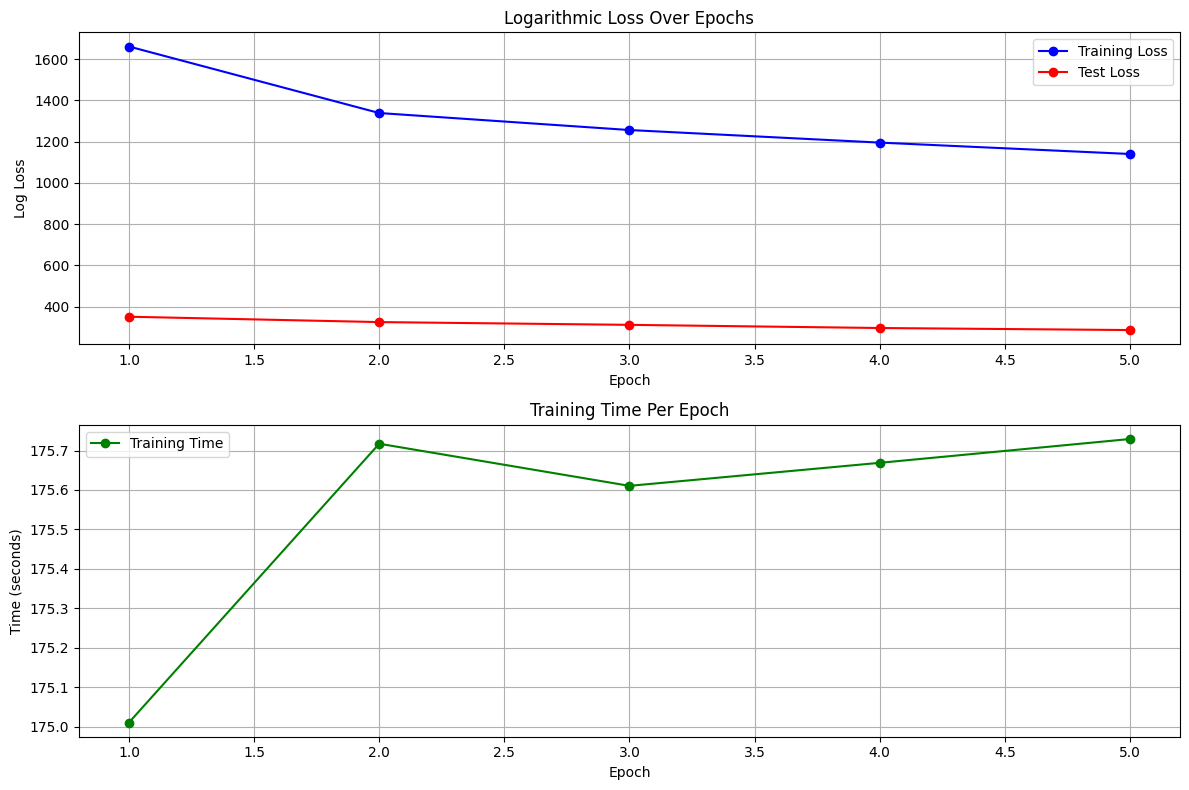

In [39]:
# Set up epoch range
epochs = range(1, 6)

# Create figure with specific size
plt.figure(figsize=(12, 8))

# Plot training and test losses on a logarithmic scale
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
plt.plot(epochs, test_losses, label='Test Loss', marker='o', color='red')
plt.title('Logarithmic Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()

# Plot training times per epoch
plt.subplot(2, 1, 2)
plt.plot(epochs, time_list, label='Training Time', marker='o', color='green')
plt.title('Training Time Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()